In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import math
from collections import defaultdict
import operator
import heapq


%matplotlib inline

## Camera Calibration

In [2]:
check_imgs = ["camera_cal/calibration"+str(i)+".jpg" for i in range(1,21)]
grid_sizes = [(9,5),(9,6),(9,6),(6,5),(7,6)]+ [(9,6)]*15

def calibration_matrix(imgs, grid_sizes):
    objpoints = []
    imgpoints = []
    for idx, fname in enumerate(imgs):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grid_size = grid_sizes[idx]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        # If found, add object points, image points
        if ret == True:
            objp = np.zeros((grid_size[0]*grid_size[1],3), np.float32)
            objp[:,:2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1,2)

            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx,dist)

mtx, dist = calibration_matrix(check_imgs,grid_sizes)

## Transformation to Birdview

In [3]:
img_size = (720,720)

def perspective_transformation(target_img_size):
    src = np.array([[592, 453], 
                    [695,453],
                    [970, 630],
                    [348, 630]], dtype = "float32")

    h_margin = 200
    top_margin = 200
    bottom_margin = 30
    dst = np.array([[h_margin, top_margin], 
                    [target_img_size[0] - h_margin, top_margin],
                    [target_img_size[0] - h_margin, target_img_size[1] - bottom_margin],
                    [h_margin, target_img_size[1] - bottom_margin]], dtype = "float32")
    return cv2.getPerspectiveTransform(src, dst)

M = perspective_transformation(img_size)
M_inv = np.linalg.inv(M)

## Define Mask

This is how the mask looks like on the birdview image


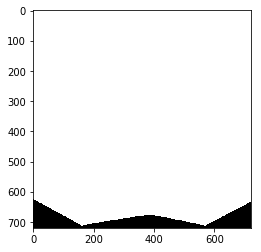

In [4]:
def region_of_interest(shape, vertices):
    #defining a blank mask to start with
    mask = np.zeros(shape,dtype=np.uint8)
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32),1)
    return mask
roi = region_of_interest((720,1280), [[300,420],[200,670],[700,600],[1150,670],[1000,420]])
roi = cv2.undistort(roi, mtx, dist, None, mtx)
roi = cv2.warpPerspective(roi, M, img_size, flags=cv2.INTER_LINEAR)
print("This is how the mask looks like on the birdview image")
plt.imshow(roi,cmap='gray')

This is how the mask looks like on the original image


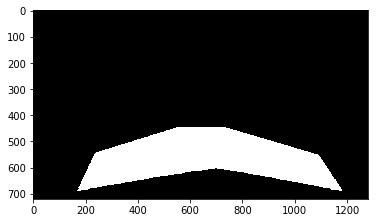

In [5]:
test = cv2.warpPerspective(roi, np.linalg.inv(M), (1280,720), flags=cv2.INTER_LINEAR)
print("This is how the mask looks like on the original image")
plt.imshow(test,cmap='gray')

## Filters

In [6]:
from Filters import topo_parabolic_bump_filter, abs_sobel_thresh, sob_filter, bump_filter

## Lane and LaneFinder
available in Lane.py and LaneFinder.py

In [7]:
mask_vertices = [[300,420],[200,670],[700,600],[1150,670],[1000,420]]
anchor_points = [[592, 453], [695,453],[970, 630],[348, 630]]
tranformed_image_size = (720,720)
PIX2XM = 3.7/330 #lane width is 3.7 meters, 430 pixels in image
PIX2YM = 3.0/60 #dash line is 3 meters long, 60 pixels in image
from LaneFinder import LaneFinder

## Test on single image

(720, 1280, 3)


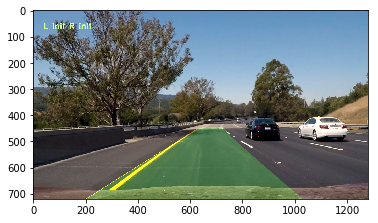

In [8]:
test_img = cv2.imread("test_images/test6.jpg")
print(test_img.shape)
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
res = lane_finder.pipeline(test_img)
plt.imshow(res)
mpimg.imsave("out.png", res)

## Test on project video

In [ ]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'project_video.mp4'
output = input_vid[:-4]+"_output.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)


In [ ]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'challenge_video.mp4'
output = input_vid[:-4]+"_overlay_polyfinder_curvature.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)

In [ ]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'harder_challenge_video.mp4'
output = input_vid[:-4]+"_overlay_polyfinder_curvature.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)

In [ ]:
from moviepy.editor import *

clip = (VideoFileClip("project_video_channels/project_video_channel_0.mp4")
        .resize(0.2))
clip.speedx(3).write_gif("channel0.gif")

In [ ]:
clip = VideoFileClip('myanimation.gif') # can be gif or movie
for frame in clip.iter_frames():
    mpimg.imsave("channel0.png",frame)
    break